## Home assignment: Feature importances


Please, fill the lines in the code below.
Your goal is to estimate importance of the existing features using several methods.

Your main goal is to estimate feature importances for Logistic Regression and Gradient Boosting using several methods.

The model should be trained using only `train` part of the data


In this task you meet the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29) describing different cars for multiclass ($k=4$) classification problem, but we use only binary subset for classes `bus` and `opel`. The data is available below.

In [173]:
# If on colab, uncomment the following lines

! wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/lab01_ml_pipeline/car_data.csv

--2024-08-21 17:10:41--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/lab01_ml_pipeline/car_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58374 (57K) [text/plain]
Saving to: ‘car_data.csv.4’

car_data.csv.4      100%[===================>]  57.01K  --.-KB/s    in 0.1s    

2024-08-21 17:10:41 (436 KB/s) - ‘car_data.csv.4’ saved [58374/58374]



In [174]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt


dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]
binary_subset = np.array([x in ['bus', 'opel'] for x in target])
data, target = data[binary_subset], target[binary_subset]

print(data.shape, target.shape)

(430, 19) (430,)


In [175]:
# do not change the code in the block below
# __________start of block__________
submission_dict = {}
# __________end of block__________

In [176]:
X_train, y_train = data[:350, 1:], target[:350]
X_val, y_val = data[350:, 1:], target[350:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(350, 18) (350,) (80, 18) (80,)


In [177]:
np.unique(y_train)

array(['bus', 'opel'], dtype=object)

#### Estimating features importances using logistic regression coefficients.
Train basic logistic regression and save its coefficients (weights).

In [178]:
lr_basic = LogisticRegression(solver='liblinear')
lr_basic.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Check the classification results on the original train data:

In [179]:
print(classification_report(y_train, lr_basic.predict(X_train)))

              precision    recall  f1-score   support

         bus       0.99      0.99      0.99       175
        opel       0.99      0.99      0.99       175

    accuracy                           0.99       350
   macro avg       0.99      0.99      0.99       350
weighted avg       0.99      0.99      0.99       350



And on validation:

In [180]:
print(classification_report(y_val, lr_basic.predict(X_val)))

              precision    recall  f1-score   support

         bus       1.00      0.95      0.98        43
        opel       0.95      1.00      0.97        37

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



Find the Logistic Regression weights and save them to the variable `lr_basic_coef`:

In [181]:
lr_basic_coef = lr_basic.coef_

It should have the same number of coefficients as number of features.

In [182]:
assert lr_basic_coef.shape[-1] == X_train.shape[1]

In [183]:
# do not change the code in the block below
# __________start of block__________
submission_dict['lr_basic_coef'] = lr_basic_coef
# __________end of block__________

#### Estimating features importances using logistic regression coefficients.
Train basic logistic regression on scaled data and save its coefficients (weights) as well

In [184]:
lr_scaled = LogisticRegression(solver='liblinear')

Use `StandardScaler` on your data.

In [185]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [186]:
lr_scaled.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

Check the classification results on the scaled train data:

In [187]:
print(classification_report(y_train, lr_scaled.predict(X_train_scaled)))

              precision    recall  f1-score   support

         bus       0.96      0.97      0.97       175
        opel       0.97      0.96      0.97       175

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



And on validation:

In [188]:
print(classification_report(y_val, lr_scaled.predict(X_val_scaled)))

              precision    recall  f1-score   support

         bus       0.98      0.98      0.98        43
        opel       0.97      0.97      0.97        37

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



Save model coefficients to the variable `lr_scaled_coef`:

In [189]:
lr_scaled_coef = lr_scaled.coef_

It should also have the same number of coefficients as number of features.

In [190]:
assert lr_scaled_coef.shape[-1] == X_train_scaled.shape[1]

Save index of the most important feature for lr_scaled to the variable `lr_scaled_most_important_index`:

In [191]:
lr_scaled_most_important_index = np.argmax(lr_scaled_coef)

In [192]:
# do not change the code in the block below
# __________start of block__________
assert isinstance(int(lr_scaled_most_important_index), int)
submission_dict['lr_scaled_coef'] = lr_scaled_coef
submission_dict['lr_scaled_most_important_index'] = lr_scaled_most_important_index
# __________end of block__________

#### Estimating features importances for logistic regression using shap
Use [`shap` library](https://shap.readthedocs.io/en/latest/index.html) to check the importance of the features. Use [`Linear` explainer](https://shap.readthedocs.io/en/latest/generated/shap.explainers.Linear.html) and the scaled data.

In [193]:
# explain the model's prediction using SHAP
explainer = shap.explainers.Linear(lr_scaled, X_train_scaled)
shap_values_scaled = explainer(X_train_scaled)

In [194]:
X_train_scaled.shape, shap_values_scaled.shape

((350, 18), (350, 18))

Summary plot:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


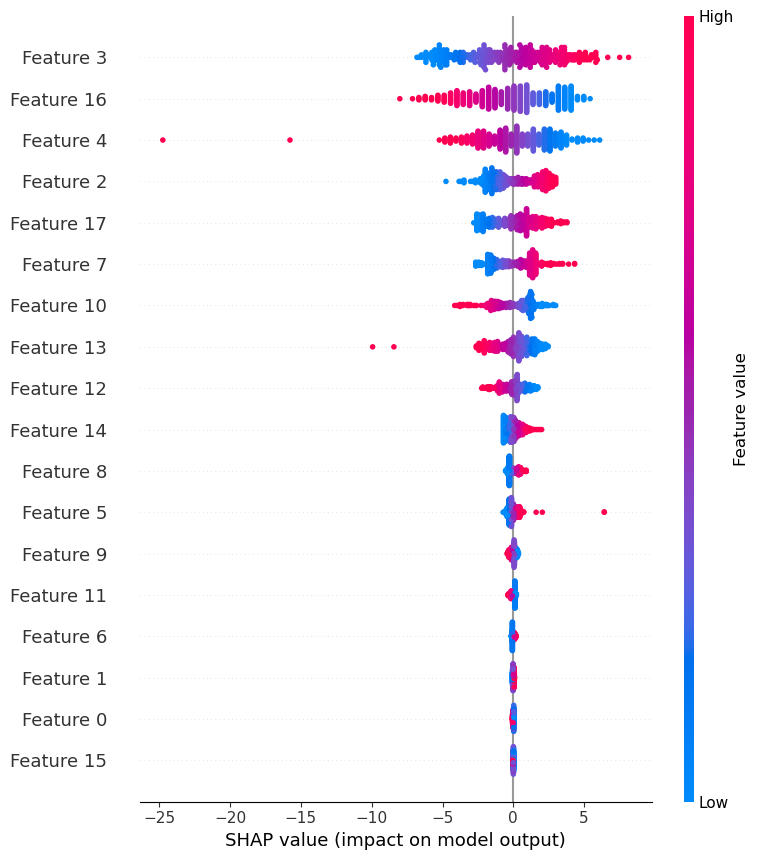

In [195]:
shap.summary_plot(shap_values_scaled, X_train_scaled)

Finally, write a function which transforms shap values to Logistic Regression coefficients. Their relations are described in the [docs](https://shap.readthedocs.io/en/latest/generated/shap.explainers.Linear.html).

*Note: This task main goal is your deeper understanding of the shap importance estimation process.*

In [196]:
shap_values_scaled.values.shape

(350, 18)

In [197]:
def get_coef_from_shap_values(shap_values, X_train_scaled):
    return np.mean(np.multiply(shap_values.values, X_train_scaled), axis=0)

In [198]:
lr_scaled_coef, get_coef_from_shap_values(shap_values_scaled, X_train_scaled)

(array([[-0.03115295,  0.04033598,  1.76454855,  3.35662949, -2.8815821 ,
          0.58315383,  0.07913508,  1.52220717,  0.34820891, -0.18397762,
         -1.41807806, -0.13653313, -0.87856133, -1.42457541,  0.53480161,
         -0.01488201, -2.9380904 ,  1.65585513]]),
 array([-0.03115295,  0.04033598,  1.76454855,  3.35662949, -2.8815821 ,
         0.58315383,  0.07913508,  1.52220717,  0.34820891, -0.18397762,
        -1.41807806, -0.13653313, -0.87856133, -1.42457541,  0.53480161,
        -0.01488201, -2.9380904 ,  1.65585513]))

In [199]:
coef_from_shap = get_coef_from_shap_values(shap_values_scaled, X_train_scaled)

If everything is correct, the next assert should pass.

In [200]:
assert np.allclose(coef_from_shap, lr_scaled_coef)

#### Training the GradientBoosting

In [201]:
gb_basic = GradientBoostingClassifier(n_estimators=10)
gb_basic.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=10)

In [202]:
gb_basic_feature_importances = gb_basic.feature_importances_

In [203]:
gb_scaled = GradientBoostingClassifier(n_estimators=10)
gb_scaled.fit(X_train_scaled, y_train)

GradientBoostingClassifier(n_estimators=10)

In [204]:
gb_scaled_feature_importances = gb_scaled.feature_importances_

In [205]:
# do not change the code in the block below
# __________start of block__________
assert np.allclose(gb_basic_feature_importances, gb_scaled_feature_importances, atol=1e-1)
submission_dict['gb_basic_feature_importances'] = gb_basic_feature_importances
# __________end of block__________

**Question:** Why are the feature importances so similar for scaled and unscaled data?

Because in tree-based models at each split we are working with feature independently. So we don't care about the scale of that feature.

#### Using shap to explain trees ensemble solution

In [206]:
explainer = shap.TreeExplainer(gb_scaled)
shap_values = explainer.shap_values(X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


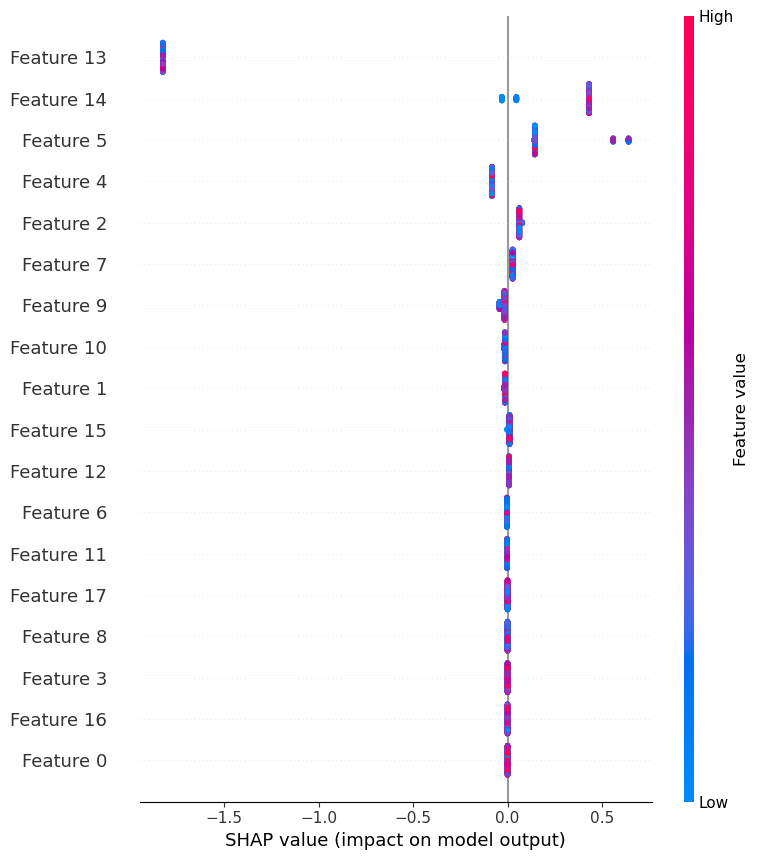

In [207]:
shap.summary_plot(shap_values, X_train)

In [208]:
gb_scaled_most_important_index = np.argmax(np.abs(np.mean(shap_values, axis=0)))

In [209]:
# do not change the code in the block below
# __________start of block__________
assert isinstance(int(gb_scaled_most_important_index), int)
submission_dict['gb_scaled_most_important_index'] = gb_scaled_most_important_index
# __________end of block__________

In [210]:
# do not change the code in the block below
# __________start of block__________
np.save('submission_dict_hw08.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw.npy`')
# __________end of block__________

File saved to `submission_dict_hw.npy`


Great job! Please, submit your solution to the grading system! Please, note, you need to submit both `submission_dict_hw.npy` and `get_coef_from_shap_values` function code.